In [1]:
#Importing the necessary libraries for this lab:
#------------------------------------------------
import networkx as nx 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import collections 
import random 
import numpy as np 
from collections import Counter
from pylab import rcParams
import powerlaw 
from itertools import count
#Magic functions (%) for setting up the matplotlib and increase the resolution of the plots:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




Graph with 410 nodes and 2765 edges


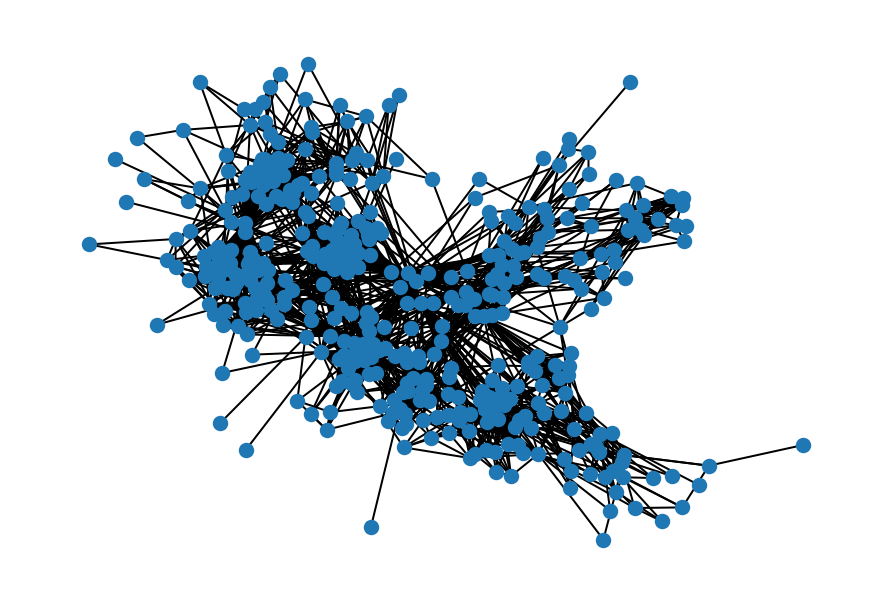

In [2]:
# Que 1.a

#Read the edges file:
fh=open('infect-dublin.edges', 'rb')
Gx=nx.read_edgelist(fh,nodetype=int, create_using=nx.Graph())

pos = nx.spring_layout(Gx) # Set the layout of the read network
#Plot the edges of the network
print(nx.info(Gx))

nx.draw(Gx,pos,node_size=45) #<-- Plot the nodes of the network

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0, 0.5, 'node idx')

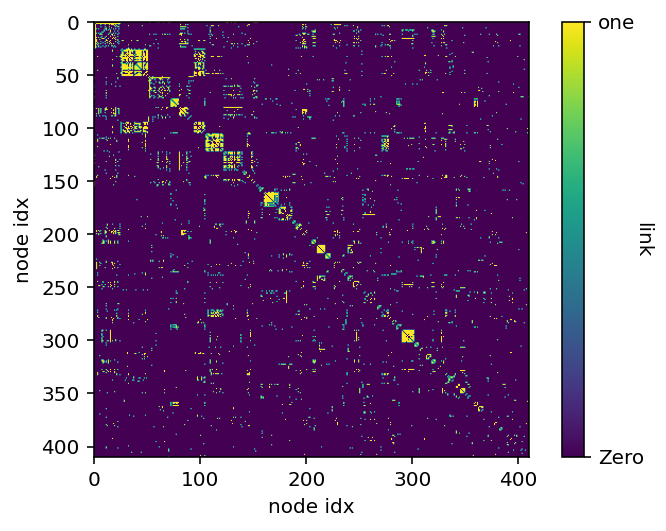

In [3]:
# Que 1.b

nx.adjacency_matrix(Gx)
print(nx.to_numpy_matrix(Gx)) #  adjacency matrix
plt.imshow(nx.to_numpy_matrix(Gx)) # creating a heatmaps from 2-D arrays.
cbar = plt.colorbar() #set the colorbar 
cbar.set_ticks([0,1]) #set the range of the color bar
cbar.ax.set_yticklabels(['Zero','one'],) #--> set the label of the number to display in the color bar

cbar.set_label('link', rotation=270) #--> set the label of the color bar and rotate it
plt.xlabel('node idx') #--> set the label of the x axis
plt.ylabel('node idx') #--> set the label of the y axis

#### SIR Model.
It has been discovered that the all the infected after a given recovery time became immune. If a node is immune and it is in contact with the infected node it does not became infected, and it will not spread the infection!

Define the function SIR_model() that inputs:

• G (a Network as networkx)

• initial_infected (nodes that are infected at time=0 as list of nodes ID)

• beta (trasmission probability as float)

• t_simulation (simulation iteration time as int)

• recovery_time (the number of days needed for the recovery.)

• nodes that are vaccinated as list of nodes ID.

Output: a dictionary that contains the nodes status at each time steps. In this case the status can be:

• ’S’ as susceptible.

• ’I’ as Infected.

• ’R’ as Recovered.

Using the network Gx and beta=0.005, t_simulation=300, initial_infected=(list of 3 random nodes), recovery_time=15, plot the number of users in each status at each simulation time step.

Second Wave.

After 100 days a second waves of the same infection start to spread on your network. Starting from the day

100: 30 people get infected randomly in your network. Keep fixed the simulation propose by the SIR Model. Randomly add at day 100, 30 new infections. If a person is infected by the second wave this set of rules applied:

• if the person was ’S’ it became infected.

• if the person was ’I’ you need to set to zero the recovery time (it will have to wait 15 days to became immune).

• ’R’ remain recovered and it is immune to the second wave.

This new infection is more easy to transmit and it has a beta=0.02! Please note that if a node is infected with infection 1 and it is still infected it can be infected but infection 2. If a node is infected with infection 2 it can not be infected with infection 1.

##  SI Model

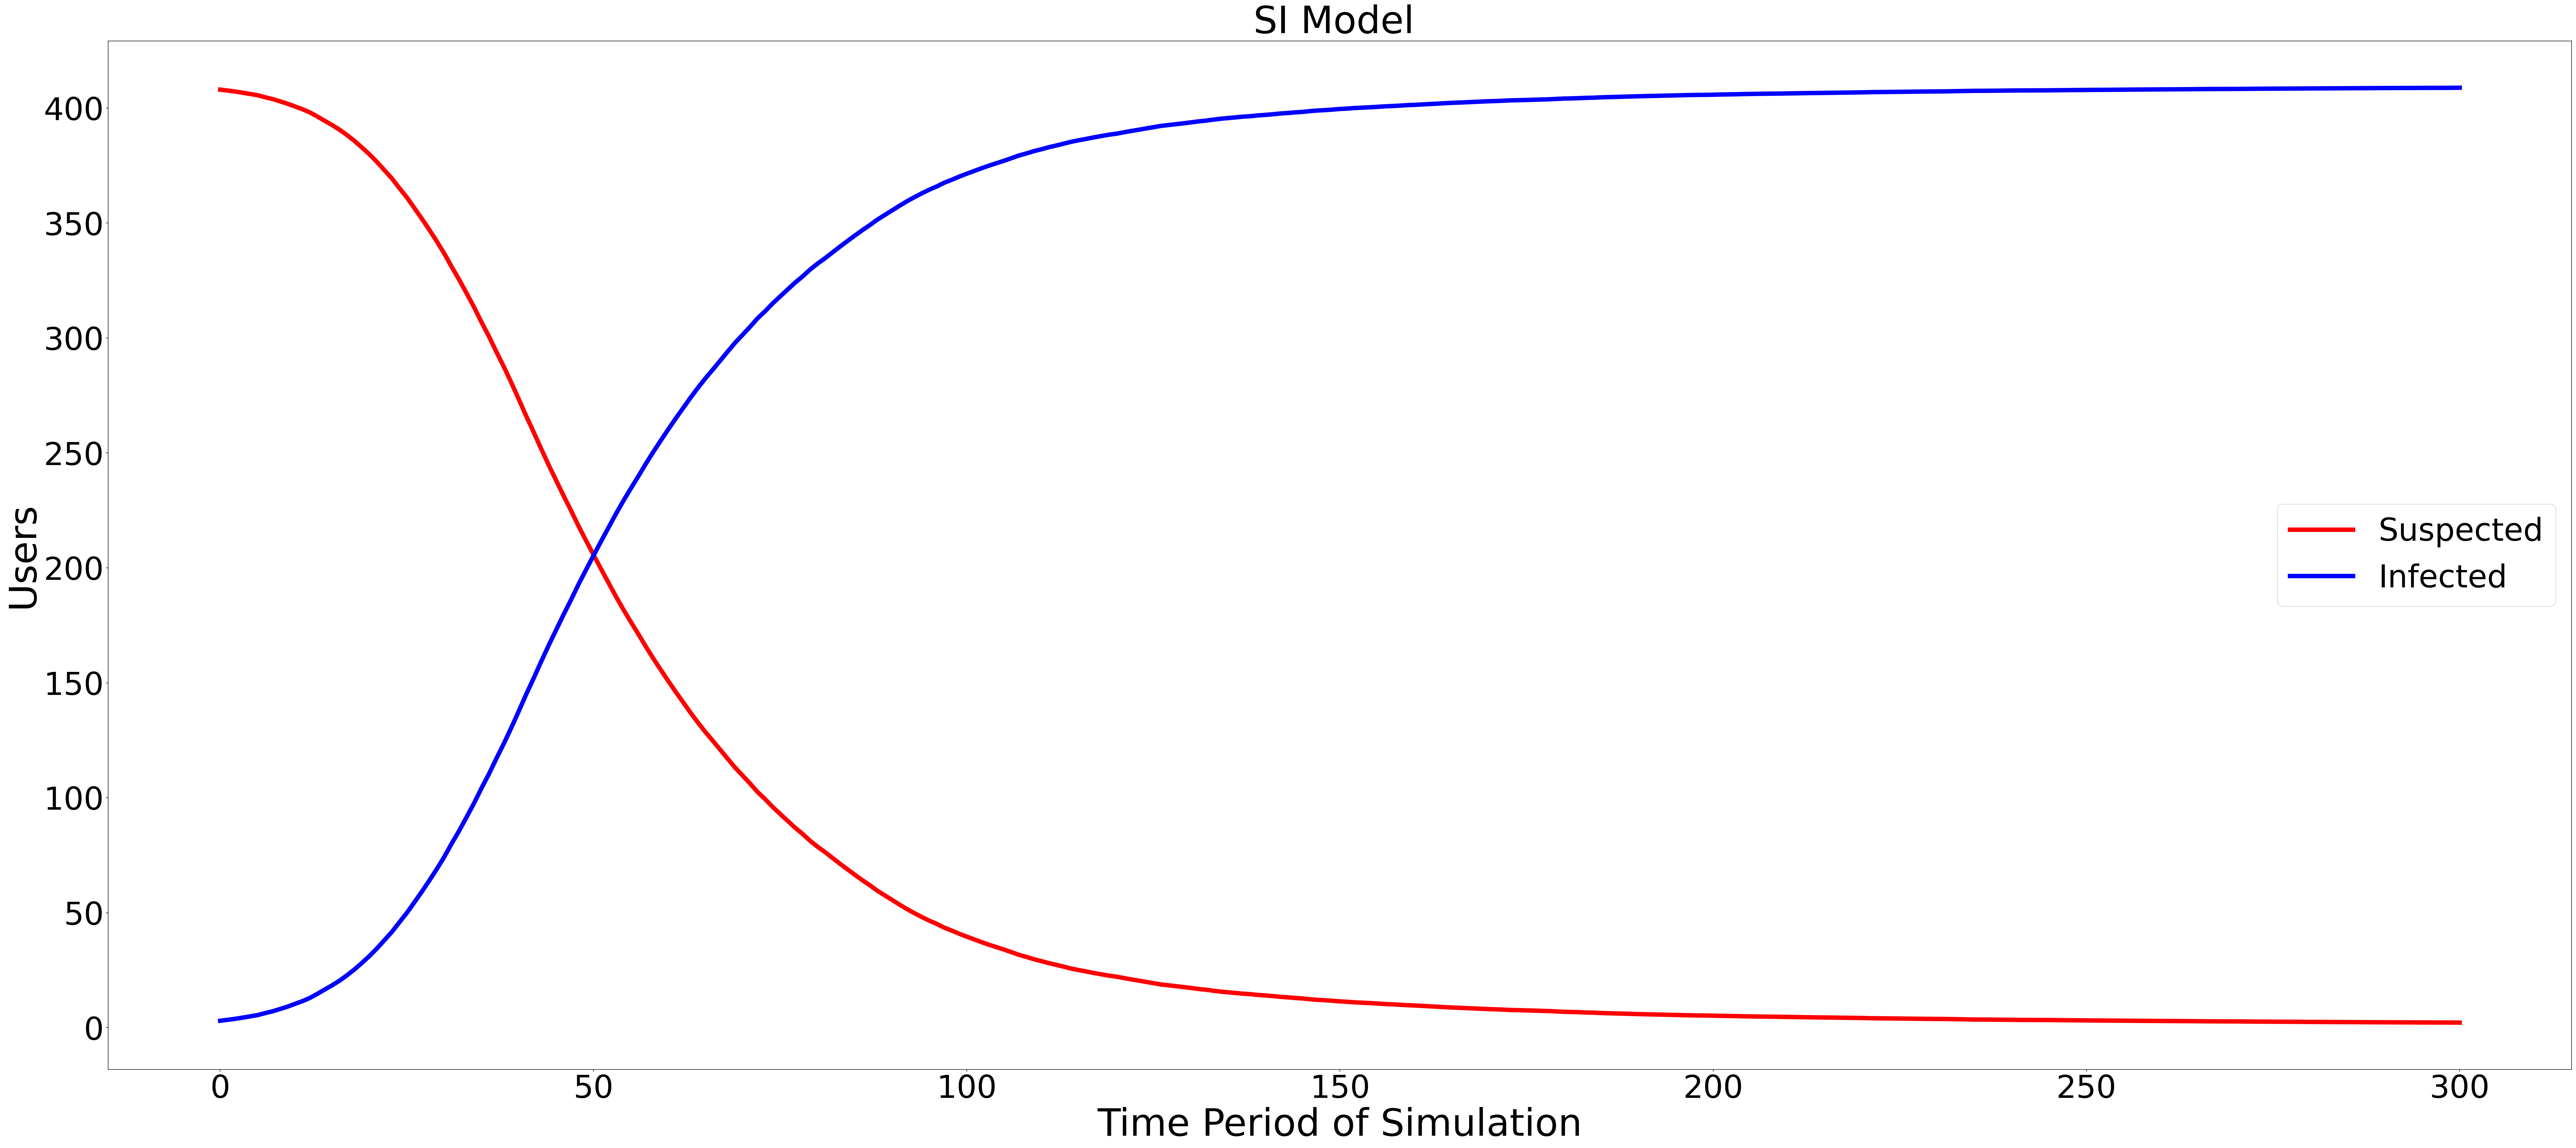

In [18]:
# Que 3.a
import time
def SI_model(A,initial_infecteds,beta,t_simulation):
       
    new_list_A=list(A.nodes)
    n=len(new_list_A)
    
    status = np.zeros([n+1, t_simulation+1]) 
    Infected_people = np.zeros(n+1,)
    
    if initial_infecteds is None:
        initial_infecteds = np.random.choice(range(n), 3)
        status[initial_infecteds,0] = 1
    else:
        status[initial_infecteds,0] = 1
                
    Infected_people[initial_infecteds] = 1
    for t in range(1, t_simulation+1):
        
        status[Infected_people>0, t] = 1
        status[Infected_people==0, t] = 0
        inf_current = np.nonzero(status[:,t])[0]
        status[inf_current, t] = 1
        for i in inf_current:
            New_list=list(nx.all_neighbors(A,i))
            New_list_curr = [n for n in New_list if np.random.uniform(0,1)<beta]
            for i in New_list_curr:
                status[i, t] = 1
                Infected_people[i] =  1
               
    status_people=np.where(status>0,"I","S")
    result={}
   
    for i in range(0, t_simulation+1):
        result[i]=status_people[:,i]
    return result
avg_su=np.zeros(300+1,)
avg_inf=np.zeros(300+1,)
for i in range(150):
    #print(i)
    start=time.time
    SI=SI_model(Gx,[10,300,50],0.01,300)
    SI_Sus=[]
    
    SI_Infected=[]
    for i in (SI.keys()):
        a=np.count_nonzero(SI[i] == "S")
        b=np.count_nonzero(SI[i] == "I")
        SI_Infected.append(b)
        SI_Sus.append(a)
    avg_su=np.add(avg_su,SI_Sus)
    avg_inf=np.add(avg_inf,SI_Infected)
SI_Infected=avg_inf/150
SI_Sus=avg_su/150
#stop=time.time()
#print(stop-start)
plt.figure(figsize=(70,30))
plt.rc('font',size='50')
plt.plot(range(len(SI_Sus)),SI_Sus,"r",label="Suspected",linewidth=7)
plt.plot(range(len(SI_Infected)),SI_Infected,"b",label="Infected",linewidth=7)
plt.legend(prop={'size': 50},fontsize=50)
plt.xlabel("Time Period of Simulation",fontsize=60)
plt.ylabel("Users",fontsize=60) 
plt.title("SI Model ")
plt.show()




<Figure size 7200x5040 with 0 Axes>

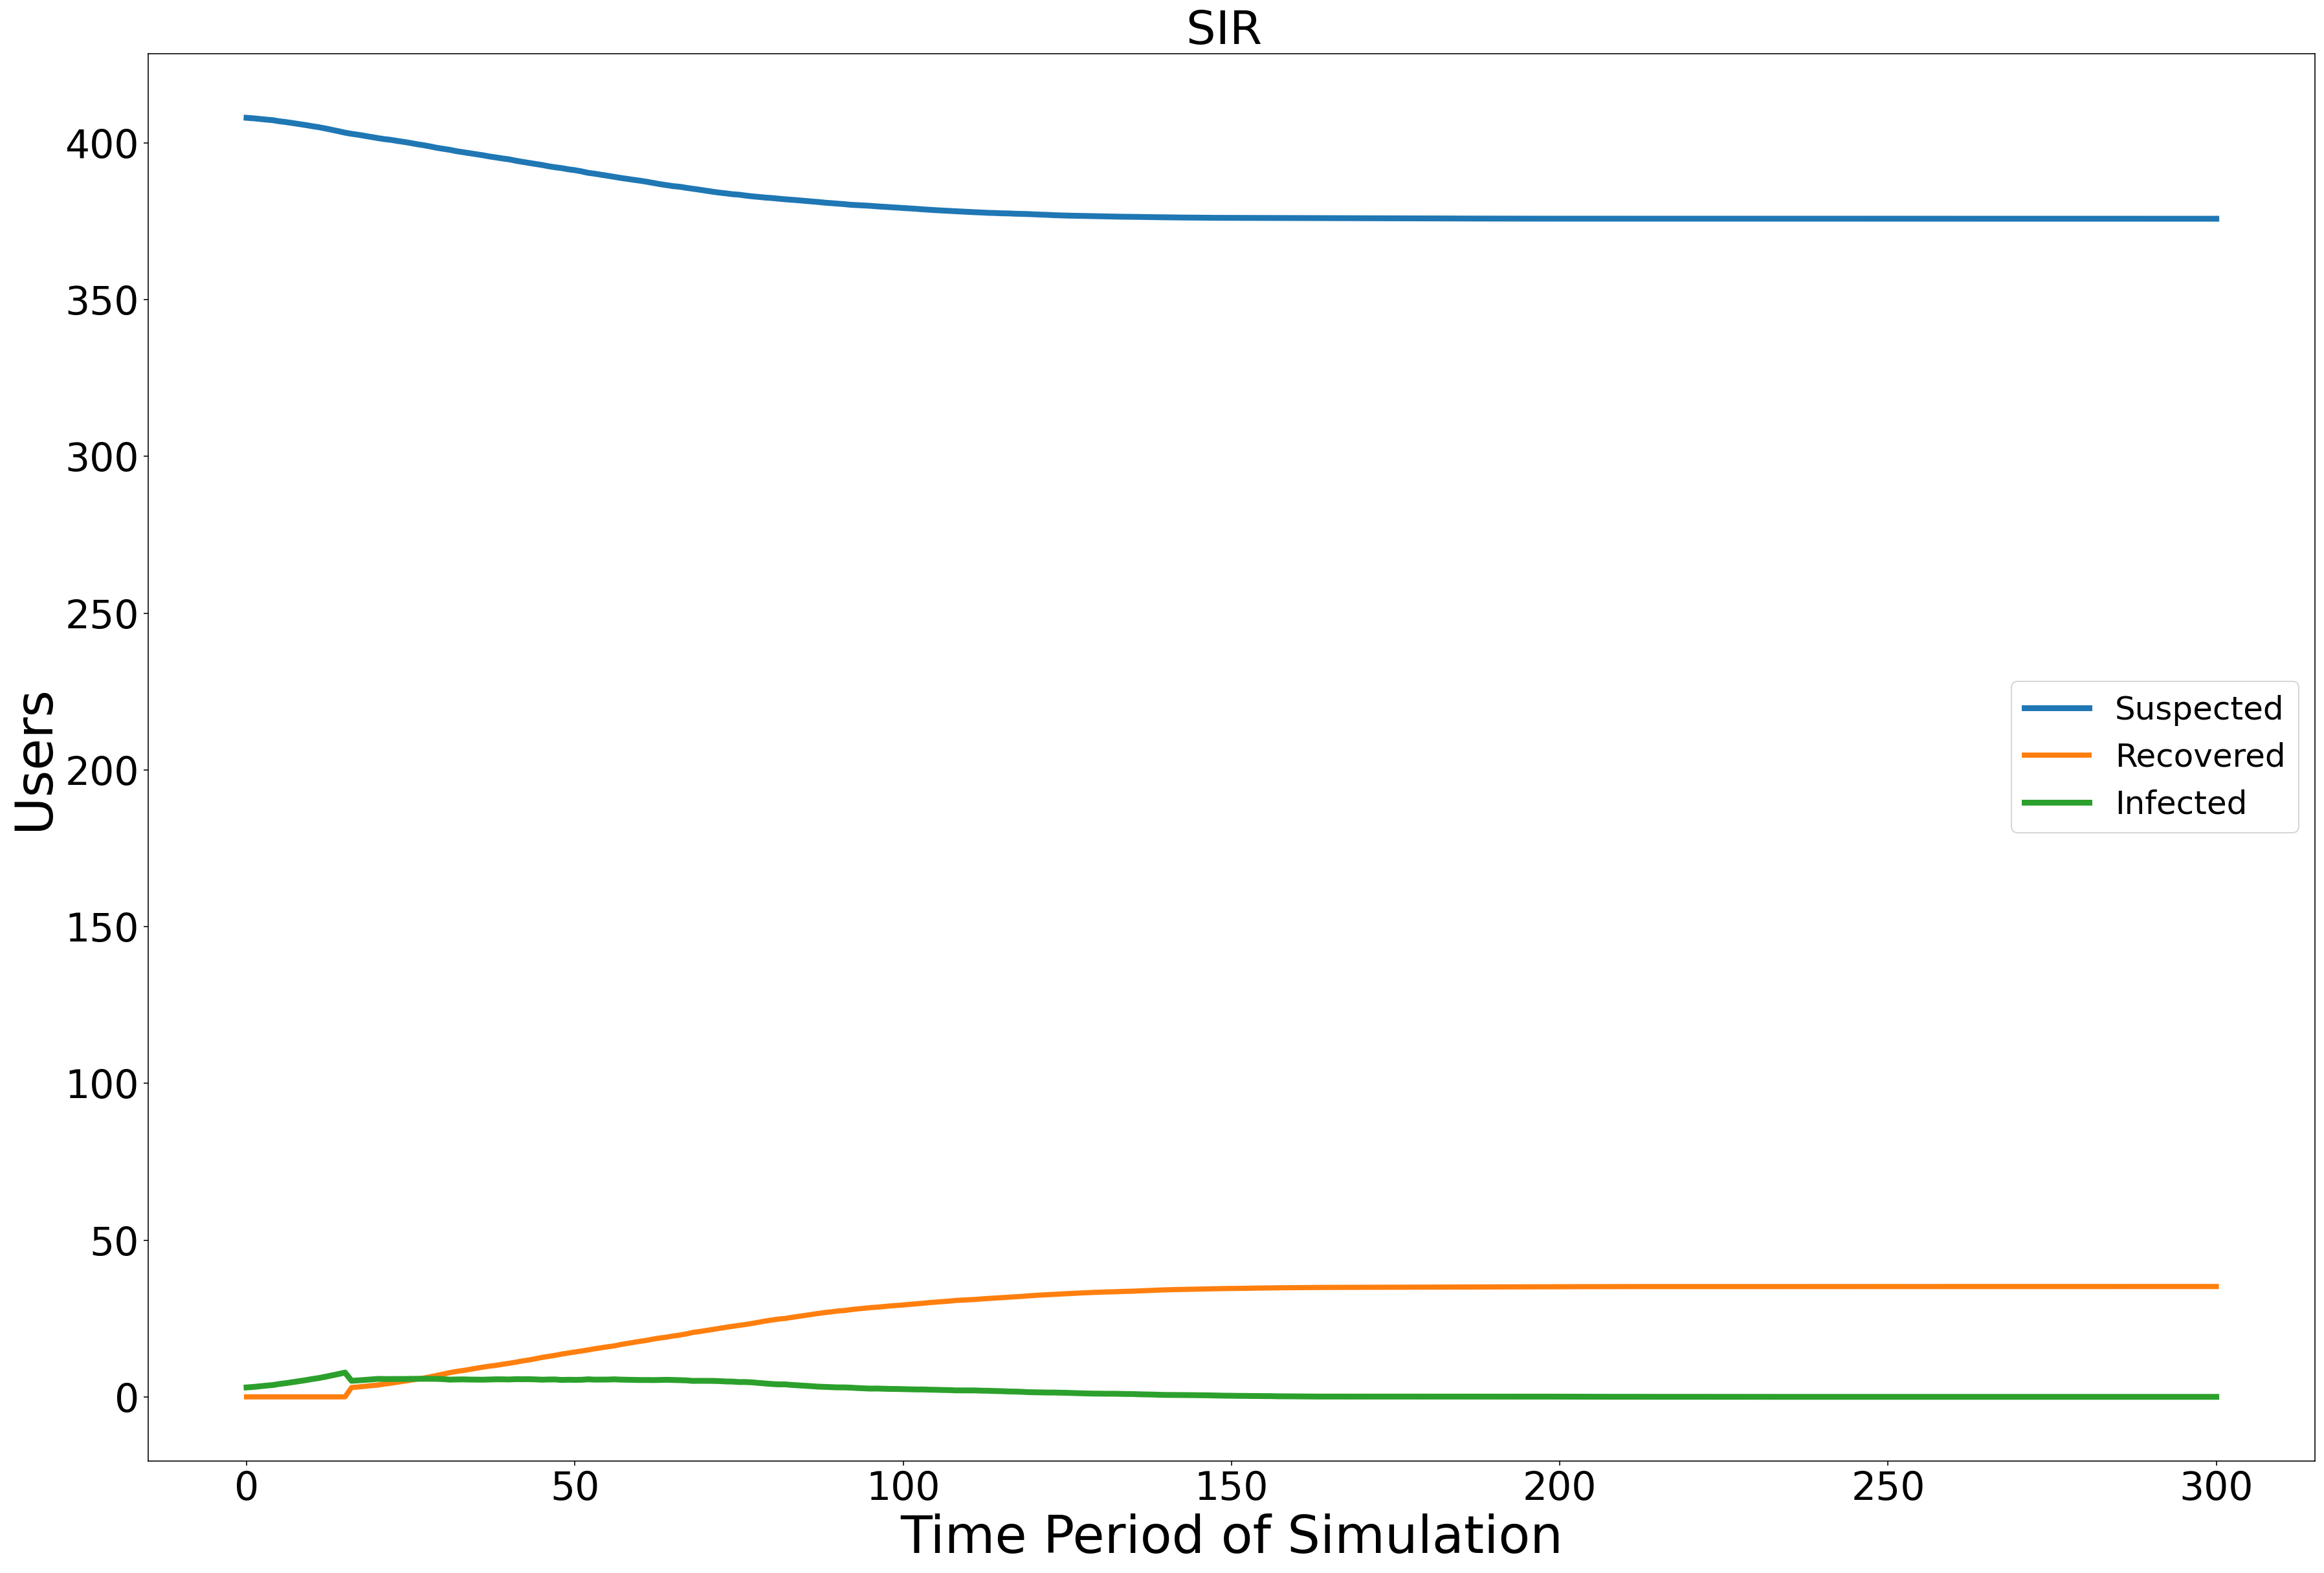

In [20]:
def SIR_model(A,initial_infecteds,beta,t_simulation,recovery_time,vaccinated):
    
    new_list_A=list(A.nodes)
    n=len(new_list_A)
    
    status = np.zeros([n+1, t_simulation+1]) 
    rec = np.zeros(n+1,)
    
    
    
    if initial_infecteds is None:
        initial_infecteds = np.random.choice(range(n), 3)
        status[initial_infecteds,0] = 1
    
    else:
        status[initial_infecteds,0] = 1
    
    rec[initial_infecteds] = recovery_time + 1
    nw=[]
    recovr=np.array(nw)
    for time in range(1, t_simulation+1):
        if 1 in rec:
            b=np.where(rec==1)
            recovr=np.append(recovr,b)
        rec = np.maximum(rec-1,0)
        status[rec>0, time] = 1
        status[rec==0, time] = 0
        for k in recovr:
            status[int(k), time] = -1
        current_in=np.where(status[:,time]>0) 
        inf=np.array(current_in).tolist()
        inf=sum(inf, [])
        status[current_in, time] = 1
        for i in inf:
            
            Neigh=list(nx.all_neighbors(A,i))
            Neigh_inf = [n for n in Neigh if np.random.uniform(0,1)<beta]
            for i in Neigh_inf:
                if rec[i]==0 and i not in recovr:
                    status[i, time] = 1
                    rec[i] = recovery_time + 1
                elif i in recovr:
                    status[i, time] = -1
    status_people=np.where(status<0,'R',(np.where(status>0,'I','S')))
    
    results={}
    for i in range(0, t_simulation+1):
        results[i]=status_people[:,i]
    return results




avg_su=np.zeros(300+1,)
avg_inf=np.zeros(300+1,)
avg_rec=np.zeros(300+1,)
avg_sec=np.zeros(300+1,)
for i in range(150):
    #print(i)
    SIR=SIR_model(Gx,[10,300,50],0.005,300,15,None)
    SIR_Recovered=[]
    SIR_Infected=[]
    SIR_Suspected=[]
    
    for j in (SIR.keys()):
        m=np. count_nonzero(SIR[j] == "I")
        n=np. count_nonzero(SIR[j] == "R")
        o=np. count_nonzero(SIR[j] == "S")
        SIR_Suspected.append(o)
        SIR_Infected.append(m)
        SIR_Recovered.append(n)
        
    avg_su=np.add(avg_su,SIR_Suspected)
    avg_inf=np.add(avg_inf,SIR_Infected)
    avg_rec=np.add(avg_rec,SIR_Recovered)
    
    
SIR_Infected=avg_inf/150
SIR_Suspected=avg_su/150 
SIR_Recovered=avg_rec/150
#print(SIR_Infected)
plt.figure(figsize=(100,70))




    
plt.figure(figsize=(30,20))  
plt.rc('font',size='30')
plt.plot(range(len(SIR_Suspected)),SIR_Suspected,label="Suspected",linewidth=4.5)
plt.plot(range(len(SIR_Recovered)),SIR_Recovered,label="Recovered",linewidth=4.)
plt.plot(range(len(SIR_Infected)),SIR_Infected,label="Infected",linewidth=4.5)
plt.legend(prop={'size': 25},fontsize=20)
plt.xlabel("Time Period of Simulation",fontsize=40)
plt.ylabel("Users",fontsize=40) 
plt.title("SIR ")

plt.show()

In [21]:
# Que 3.c

def SIR_second_wave_mode(A,initial_infecteds,beta,t_simulation,recovery_time):
    
    
    new_list_A=list(A.nodes)
    n=len(new_list_A)
    
    status = np.zeros([n+1, t_simulation+1]) 
    rec = np.zeros(n+1,)
    
    
    if initial_infecteds is None:
        initial_infecteds = np.random.choice(range(n), 3)
        status[initial_infecteds,0] = 1
    else:
        status[initial_infecteds,0] = 1
        
    
    
    rec[initial_infecteds] = recovery_time + 1
    nw=[]
    recovr=np.array(nw)
    second_wave=np.array(nw)
    # Start simulation
    for time in range(1, t_simulation+1):
        if time==101:
            
            time_list= [x for x in new_list_A if x not in recovr]
            Second_infected = np.random.choice(time_list, 30)
            rec[Second_infected] = recovery_time + 1
            second_wave=np.append(second_wave,Second_infected)
        if 1 in rec:
            a=np.where(rec==1)
            recovr=np.append(recovr,a)
            
            
        rec = np.maximum(rec-1,0)
        
        status[rec>0, time] = 1
        status[rec==0, time] = 0       
        for i in recovr:
            
            status[int(i), time] = -1
        for j in second_wave:
            status[int(j), time] = 2
        
        infect_first=np.where(status[:,time]==1) 
        Infect1=np.array(infect_first).tolist()
        Infect1=sum(Infect1, [])
        infect_second=np.where(status[:,time]==2) 
        Infect2=np.array(infect_second).tolist()
        
        Infect2=sum(Infect2, [])
        
        for i in Infect1:
            
            
            Neigh=list(nx.all_neighbors(A,i))
            
            Neigh_inf = [n for n in Neigh if np.random.uniform(0,1)<beta]
            for i in Neigh_inf:
                if rec[i]==0 and i not in recovr and i not in second_wave:
                    
                    status[i, time] = 1
                    rec[i] = recovery_time + 1
                elif i in recovr:
                    status[i, time] = -1
        
        for i in Infect2:
            Neigh=list(nx.all_neighbors(A,i))
            
            Neigh_inf = [n for n in Neigh if np.random.uniform(0,1)<0.02]
            for i in Neigh_inf:
                if rec[i]==0 and i not in recovr:
                    
                    status[i, time] = 2
                    rec[i] = recovery_time + 1
                    second_wave=np.append(second_wave,i)
                elif i in recovr:
                    status[i, time] = -1
                    
                
            
                
           
    status_people=np.where(status<0,'R',(np.where(status==0,'S',np.where(status>1,'2W','I'))))
    status_people[status<0]='R'
    status_people[status==1]='I'
    status_people[status==0]='S'
    status_people[status==2]="2W"
    results={}
   
    for i in range(0, t_simulation+1):
        results[i]=status_people[:,i]
    return results



avg_su=np.zeros(300+1,)
avg_inf=np.zeros(300+1,)
avg_rec=np.zeros(300+1,)
avg_sec=np.zeros(300+1,)
for i in range(150):
    
    SIR_second_wave_model=SIR_second_wave_mode(Gx,[10,300,50],0.02,300,15)
    SW_SIR_Recovered=[]
    SW_SIR_Infected=[]
    SW_SIR_Suspected=[]
    SW_Infect=[]
    for i in (SIR_second_wave_model.keys()):
        
        p=np.count_nonzero(SIR_second_wave_model[i] == "R")
        q=np.count_nonzero(SIR_second_wave_model[i] == "S")
        r=np.count_nonzero(SIR_second_wave_model[i] == "I")
        s=np.count_nonzero(SIR_second_wave_model[i] == "2W")
        SW_SIR_Recovered.append(p)
        SW_SIR_Infected.append(r)
        SW_SIR_Suspected.append(q)
        SW_Infect.append(s)
    avg_su=np.add(avg_su,SW_SIR_Suspected)
    avg_inf=np.add(avg_inf,SW_SIR_Infected)
    avg_rec=np.add(avg_rec,SW_SIR_Recovered)
    avg_sec=np.add(avg_sec,SW_Infect)
    
SW_SIR_Infected=avg_inf/150
SW_SIR_Suspected=avg_su/150 
SW_SIR_Recovered=avg_rec/150
SW_Infect=avg_sec/150
plt.figure(figsize=(100,70))
plt.rc('font',size='70')
plt.plot(range(len(SW_SIR_Suspected)),SW_SIR_Suspected,"m",label="SW Suspected",linewidth=7)
plt.plot(range(len(SW_SIR_Recovered)),SW_SIR_Recovered,"r",label="SW Recovered",linewidth=7)
plt.plot(range(len(SW_SIR_Infected)),SW_SIR_Infected,"g",label="SW Infected",linewidth=7)
plt.plot(range(len(SW_Infect)),SW_Infect,"b",label="second wave infected",linewidth=7)
plt.xlabel(" time of simulation",fontsize=80)
plt.ylabel(" Users",fontsize=70) 
plt.title("SIR_second_wave_model model",fontsize=70)
plt.legend(prop={'size': 70},fontsize=70)
plt.show()

In [22]:
# Que 3.d

plt.figure(figsize=(100,70))
plt.plot(range(len(SI_Sus)),SI_Sus,label="suspected",linestyle=":",linewidth=8)
plt.plot(range(len(SI_Infected)),SI_Infected,"m",label="infected",linestyle=":",linewidth=8)
plt.plot(range(len(SIR_Suspected)),SIR_Suspected,label="SIR_suspected",linewidth=8)
plt.plot(range(len(SIR_Recovered)),SIR_Recovered,label="SIR_recovered",linewidth=8)
plt.plot(range(len(SIR_Infected)),SIR_Infected,"c",label="SIR_infected",linewidth=8)
plt.plot(range(len(SW_SIR_Suspected)),SW_SIR_Suspected,label="SW Suspected",linestyle="--",linewidth=8)
plt.plot(range(len(SW_SIR_Recovered)),SW_SIR_Recovered,"r",label="SW Recovered",linestyle="--",linewidth=8)
plt.plot(range(len(SW_SIR_Infected)),SW_SIR_Infected,"y",label="SW Infected",linestyle="--",linewidth=8)
plt.plot(range(len(SW_Infect)),SW_Infect,"b",label="second wave infected",linestyle="--",linewidth=8)

plt.xlabel("Simulation time")
plt.ylabel("Number of users") 
plt.title("model")

plt.legend(loc='upper right',prop={'size': 70},fontsize=70)
plt.show()

### 1. We can observe from the SI Model that the Suspected nodes and the infected nodes remain constant as the total population remain same.
### As for the SIR model we an observe that, the sum of suspected , infected and recovered is constant. 
### Another point to note is just as recovered infections decline wherein the infections become recovered,
### the infection rate increases slightly but then decreases drastically.

### When we introduce a second wave of infections, the infection rate rises initially and whereas susceptible rate decresease where they finally plateaus.